In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
pd.set_option('mode.chained_assignment', None)

## Carga de datos

In [2]:
df = pd.read_csv('caudal_extra.csv.zip', index_col=0)
df.head(5)

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,codigo_estacion,institucion,fuente,nombre,altura,latitud,longitud,codigo_cuenca,nombre_sub_cuenca,cantidad_observaciones,fecha,caudal,gauge_id,gauge_name,precip_promedio,temp_max_promedio
0,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.6833,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1960-01-06 00:00:00+00:00,0.812,4540001,Rio Grande En Paloma 1,0.0,NaN
1,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.6833,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1960-03-27 00:00:00+00:00,0.236,4540001,Rio Grande En Paloma 1,0.0,NaN
2,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.6833,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1960-05-07 00:00:00+00:00,0.730,4540001,Rio Grande En Paloma 1,0.0,NaN
3,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.6833,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1960-06-30 00:00:00+00:00,3.590,4540001,Rio Grande En Paloma 1,0.0,NaN
4,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.6833,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1960-07-22 00:00:00+00:00,1.370,4540001,Rio Grande En Paloma 1,0.0,NaN


In [3]:
print('cantidad de datos duplicados', df.duplicated().sum())

cantidad de datos duplicados 0


Exploraremos la metadata del dataframe a ver si los datos están cargados correctamente, y veremos si existen missing values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1411180 entries, 0 to 1411179
Data columns (total 16 columns):
codigo_estacion           1411180 non-null int64
institucion               1411180 non-null object
fuente                    1411180 non-null object
nombre                    1411180 non-null object
altura                    1411180 non-null int64
latitud                   1411180 non-null float64
longitud                  1411180 non-null float64
codigo_cuenca             1411180 non-null int64
nombre_sub_cuenca         1411180 non-null object
cantidad_observaciones    1411180 non-null int64
fecha                     1411180 non-null object
caudal                    1411180 non-null float64
gauge_id                  1411180 non-null int64
gauge_name                1411180 non-null object
precip_promedio           1383413 non-null float64
temp_max_promedio         1259617 non-null float64
dtypes: float64(5), int64(5), object(6)
memory usage: 183.0+ MB


Tenemos 16 columnas de las cuales 14 no tienen missing values. Las columnas precip_promedio y temp_max_promedio, contienen 27.767 y 151.563 NaN respectivamente, esto puede deberse al hecho de que no existían estaciones medidoras en esa cuenca en ese período, y como es una medición diaria, se producen muchos missing values.

Hay algunas columnas que no estan muy bien explicadas en el desafío como por ejemplo codigo_cuenca de la cual hay 29 tipos (estoy pensando que puede ser una cuenca mas grande a la que pertenece esta subcuenca) o a que se refiere cantidad_observaciones, pero intentaremos ver si sirven de algo más adelante.

Además la fecha está como objeto y no reconocida como fecha, por lo que la convertiremos a datetime

In [5]:
# Convertimos fecha a datetime
df['fecha'] =  pd.to_datetime(df['fecha']).dt.tz_localize(None)

In [6]:
# Ademas eliminaremos las columnas que no nos servirán para este análisis debido a que 
# no contienen informacion relevante para este modelamiento

df = df.drop(columns=['institucion', 'fuente', 'nombre', 'altura', 'latitud', 'longitud', 
                     'codigo_cuenca', 'nombre_sub_cuenca', 'cantidad_observaciones', 'gauge_id', 'gauge_name'], axis=1)

### Distribucion variables relevantes

En esta sección analizaremos las variables relevantes según el desafío, que son el caudal, la temperatura max promedio y la precipitación promedio, para ver si podemos caracterizar de alguna forma las cuencas

Primero veremos la distribucion de la cantidad de observaciones por estación, esto puede influir a la hora de hacer predicciones porque algunas tendrán mas información que otras.

In [7]:
n_por_estacion = df[['codigo_estacion', 'caudal', 'temp_max_promedio', 'precip_promedio']].groupby('codigo_estacion').count().add_suffix('_Count').reset_index()
n_por_estacion.head(5)

,codigo_estacion,caudal_Count,temp_max_promedio_Count,precip_promedio_Count
0,1020003,12194,11141,12194
1,1021001,12043,9534,12043
2,1050004,10943,10411,10843
3,1211001,8780,7048,8750
4,2103003,2596,2563,2596


In [8]:
n_por_estacion.describe()

,codigo_estacion,caudal_Count,temp_max_promedio_Count,precip_promedio_Count
count,1.330000e+02,133.000000,133.000000,133.000000
mean,6.619852e+06,10610.375940,9470.804511,10401.601504
std,3.165929e+06,5784.779294,4978.607703,5692.342851
min,1.020003e+06,802.000000,790.000000,1.000000
25%,4.320001e+06,5524.000000,5361.000000,5462.000000
50%,7.116001e+06,10255.000000,9091.000000,9607.000000
75%,8.380006e+06,15677.000000,14542.000000,15642.000000
max,1.287600e+07,20706.000000,19631.000000,20647.000000


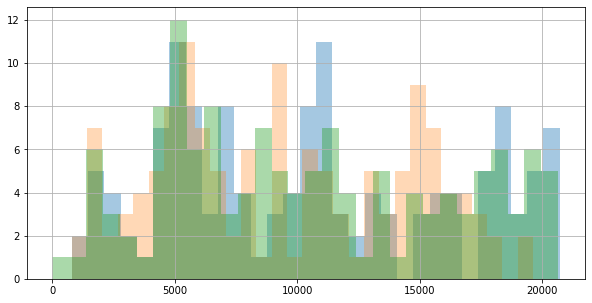

In [9]:
n_por_estacion.caudal_Count.hist(alpha=0.4, bins=30, figsize=(10,5))
n_por_estacion.temp_max_promedio_Count.hist(alpha=0.3, bins=30)
n_por_estacion.precip_promedio_Count.hist(alpha=0.4, bins=30)

Podemos ver que la distribución de las observaciones entre cuencas no es muy uniforme, tenemos un 25% inferior de las cuencas donde hay alrededor de 5.500 observaciones por variable, y otras cuencas en el 25% superior donde tienen 15.000 observaciones por cada medición. Esto puede influir a la hora de crear nuestros eventos extremos ya que pueden haber datos ocultos para las estaciones con menores medidas

Tambien analizaremos la distribucion de los valores de estas medidas

In [10]:
media_por_estacion = df[['codigo_estacion', 'caudal', 'temp_max_promedio', 'precip_promedio']].groupby('codigo_estacion').mean().add_suffix('_mean').reset_index()
media_por_estacion.head(5)

,codigo_estacion,caudal_mean,temp_max_promedio_mean,precip_promedio_mean
0,1020003,0.144569,11.476255,0.951037
1,1021001,2.538351,11.631694,0.884537
2,1050004,0.171735,14.283326,0.340518
3,1211001,1.279278,14.161425,0.582896
4,2103003,0.061300,14.619398,0.187192


In [11]:
media_por_estacion.describe()

,codigo_estacion,caudal_mean,temp_max_promedio_mean,precip_promedio_mean
count,1.330000e+02,133.000000,133.000000,133.000000
mean,6.619852e+06,119.725845,18.586741,2.007494
std,3.165929e+06,206.779491,4.345025,1.843316
min,1.020003e+06,0.061300,9.637564,0.099341
25%,4.320001e+06,3.116892,15.226925,0.371899
50%,7.116001e+06,15.857596,18.622616,1.245224
75%,8.380006e+06,126.073153,21.758131,3.569124
max,1.287600e+07,954.011219,28.471567,6.950711


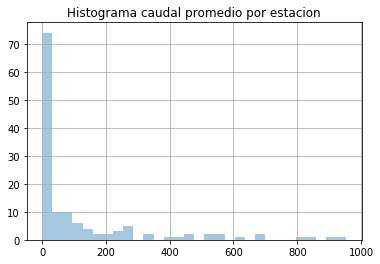

In [12]:
plt.title('Histograma caudal promedio por estacion')
media_por_estacion.caudal_mean.hist(alpha=0.4, bins=30)

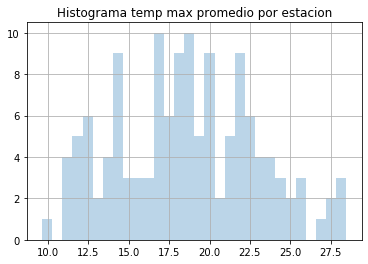

In [13]:
plt.title('Histograma temp max promedio por estacion')
media_por_estacion.temp_max_promedio_mean.hist(alpha=0.3, bins=30)

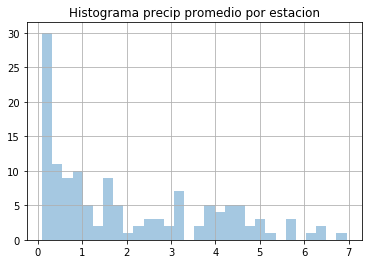

In [14]:
plt.title('Histograma precip promedio por estacion')
media_por_estacion.precip_promedio_mean.hist(alpha=0.4, bins=30)

Creo que este análisis es muy valioso porque nos muestra que las cuencas son muy diferentes entre si. En cuanto al caudal, la distribucion es muy dispareja, la media es alrededor de 8 veces la mediana por lo que tenemos muchas cuencas con caudales pequeños y algunas cuencas con caudales muy grandes. La distribucion del promedio de temperatura es un poco mas pareja, pero aun así tenemos un rango entre 15 y 21º que abarca sólo el 50% de las cuencas. 

Finalmente la precipitacion promedio es bastante pequeña para las cuencas, pero esto es influido porque muchos de los días no llueve, por lo que la medición es 0. Aún así es importante destacar que en el 25% inferior (0.37) llueve 10 veces menos que en el 25% superior (3.5)

### Missing values

Creo que es importante ver si estos missing values están repartidos *equitativamente* entre cuencas, o se deben quizás a que unas cuencas tienen condiciones que hacen que medir temperatura o precipitación sea más dificil

Primero calcularemos la frecuencia de missing values en precipitacion por cuenca

In [15]:
missing_por_cuencas = df.precip_promedio.isnull().groupby([df['codigo_estacion']]).sum().astype(int).reset_index(name='count')
print('cantidad de missing values precipitacion')
print('missing values, freq')
print(missing_por_cuencas['count'].value_counts())

cantidad de missing values precipitacion
missing values, freq
0       85
1        4
61       3
31       2
18       2
3        2
2        2
6        1
3591     1
12       1
15       1
16       1
2101     1
2077     1
30       1
801      1
34       1
36       1
1072     1
49       1
2297     1
756      1
112      1
1497     1
1485     1
3019     1
941      1
1027     1
916      1
399      1
104      1
59       1
100      1
610      1
97       1
92       1
91       1
840      1
1598     1
1592     1
Name: count, dtype: int64


Ahora calcularemos la frecuencia de missing values en temperatura por cuenca

In [16]:
missing_por_cuencas = df.temp_max_promedio.isnull().groupby([df['codigo_estacion']]).sum().astype(int).reset_index(name='count')
print('cantidad de missing values temperatura')
print('missing values, freq')
print(missing_por_cuencas['count'].value_counts())

cantidad de missing values temperatura
missing values, freq
0       24
1        6
4        3
5        3
66       1
306      1
3        1
1079     1
570      1
3906     1
1340     1
205      1
881      1
1088     1
1091     1
44       1
513      1
845      1
1358     1
1776     1
80       1
2780     1
339      1
87       1
1624     1
3887     1
40       1
2859     1
3597     1
2        1
        ..
1507     1
1233     1
1511     1
1008     1
673      1
3487     1
1485     1
5019     1
351      1
609      1
610      1
2404     1
2661     1
5225     1
5482     1
778      1
12       1
112      1
113      1
1397     1
13       1
2694     1
1931     1
3212     1
5261     1
2193     1
663      1
2969     1
154      1
2139     1
Name: count, Length: 101, dtype: int64


Podemos ver de estas tabla de frecuencia que 85 de 133 estaciones (64%) no tienen missing values  en precipitación y que 24 de 133 (18%) no tienen missing values en temperatura máxima promedio. Aun así hay muchas estaciones que tienen un pequeño número de missing values (aún confiables) y por ejemplo sólo 11 estaciones tienen más de 1000 missing values en precipitación. Creo que esto es importante a la hora de modelar, porque probablemente estas estaciones no sean tan fidedignas. Podríamos imputar los datos con un promedio entre los días que si tienen medidas, o buscando más data externamente con zonas aledañas geográficamente

# Plotting

Escribir una función que tome como input una estación y haga plot de los datos para
una columna

In [17]:
def time_plot_una_estacion(codigo_estacion, columna, fecha_min, fecha_max):
    '''
    Esta función grafica una medida para una estación determinada entre dos fechas
    
     Argumentos
    ----------
    codigo_estacion : int
        codigo correspondiente a la estación de medición de caudal
    columna : str
        nombre de la columna correspondiente a la medida, puede ser "caudal", "precip_promedio" o "temp_max_promedio"
    fecha_min : datetime
        fecha inicial para el gráfico en formato 'YYYY-MM-DD'
    fecha_max : datetime
        fecha final para el gráfico en formato 'YYYY-MM-DD'
    '''
    try:
        data_plot = df[['fecha', columna]][df['codigo_estacion'] == codigo_estacion].set_index('fecha')
        data_plot = data_plot[fecha_min : fecha_max]
        data_plot.plot(title=('Estacion ' + str(codigo_estacion)), figsize=(10,5))
    except:
        print("Ocurrió un error, por favor revisa los inputs")
        print(time_plot_una_estacion.__doc__)

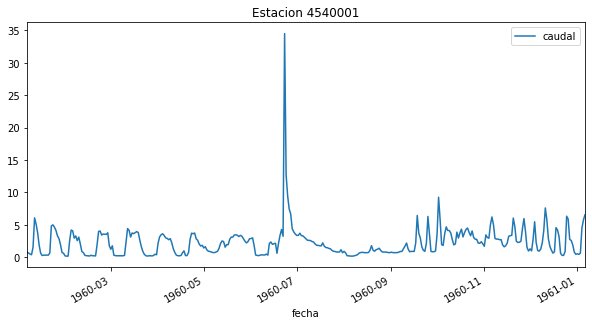

In [18]:
time_plot_una_estacion(4540001, "caudal", '1960-01-06', '1961-01-06')

Plot de varias columnas con escala normalizada, elegi una normalización min-max porque me pareció la mas adecuada, representar todas las variables con respecto a ellas mismas en una escala [0,1]

In [19]:
def time_plot_estaciones_varias_columnas(codigo_estacion, columnas, fecha_min, fecha_max):
    '''
    Esta función grafica una o mas medidas para una estación determinada entre dos fechas
    
     Argumentos
    ----------
    codigo_estacion : int
        codigo correspondiente a la estación de medición de caudal
    columnas : list
        lista de medidas a graficar entre brackets "[]", por ej: "["caudal", "precip_promedio"]"
    fecha_min : datetime
        fecha inicial para el gráfico en formato 'YYYY-MM-DD'
    fecha_max : datetime
        fecha final para el gráfico en formato 'YYYY-MM-DD'
    '''
    try:
        cols = columnas.append('fecha')
        data_plot_varios = df[columnas][df['codigo_estacion'] == codigo_estacion].set_index('fecha')
        data_plot_varios = data_plot_varios[fecha_min : fecha_max]
        scaler = MinMaxScaler()
        valores_escalados = scaler.fit_transform(data_plot_varios)
        data_plot_varios.loc[:,:] = valores_escalados
        data_plot_varios.plot(title=('Estacion ' + str(codigo_estacion) + ', columnas normalizadas [0,1]'), figsize=(10,5))
    except:
        print("Ocurrió un error, por favor revisa los inputs")
        print(time_plot_estaciones_varias_columnas.__doc__)

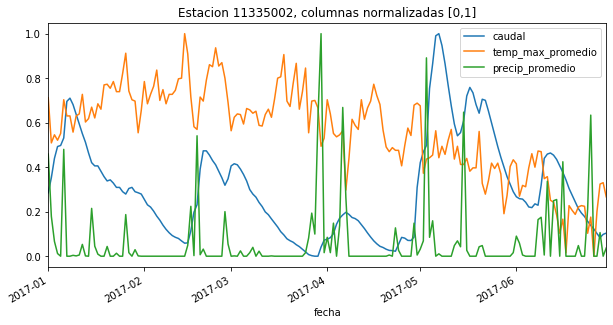

In [20]:
time_plot_estaciones_varias_columnas(11335002, ["caudal", "temp_max_promedio", "precip_promedio"], '2017-01-01' , '2017-07-01' )

# Creación de variables

In [21]:
# Creando variables para mes y año
df['mes'] = pd.DatetimeIndex(df['fecha']).month
df['ano'] = pd.DatetimeIndex(df['fecha']).year
# Creando variables para extremos y llenando con NaN donde existían anteriormente
df['caudal_extremo'] = 0
df['temp_extremo'] = 0
df['precip_extremo'] = 0
df['temp_extremo'][df['temp_max_promedio'].isna()] = np.NaN
df['precip_extremo'][df['precip_promedio'].isna()] = np.NaN

In [22]:
# Creando variable para estacion
df['estacion'] = ""

In [23]:
# Asignando estacion a cada mes, hice un supuesto para simplificar la asignación 
# por lo que considero que la estación comienza en el 1ero de cada mes y no el equinoccio

df['estacion'][df['mes'] == 1] = 'verano'
df['estacion'][df['mes'] == 2] = 'verano'
df['estacion'][df['mes'] == 3] = 'verano'
df['estacion'][df['mes'] == 4] = 'otono'
df['estacion'][df['mes'] == 5] = 'otono'
df['estacion'][df['mes'] == 6] = 'otono'
df['estacion'][df['mes'] == 7] = 'invierno'
df['estacion'][df['mes'] == 8] = 'invierno'
df['estacion'][df['mes'] == 9] = 'invierno'
df['estacion'][df['mes'] == 10] = 'primavera'
df['estacion'][df['mes'] == 11] = 'primavera'
df['estacion'][df['mes'] == 12] = 'primavera'

In [24]:
# creando tabla auxiliar con cálculos de p95 para cada estación y cada época
estaciones = df.codigo_estacion.unique()
seasons = ["verano"] * 133 + ["otono"] * 133 + ["invierno"] * 133 + ["primavera"] * 133

aux = pd.DataFrame(list(zip(list(estaciones) * 4, seasons)), 
               columns =['codigo_estacion', 'estacion']) 

aux['p95_caudal'] = 0
aux['p95_temp'] = 0
aux['p95_precp'] = 0


for i in estaciones:
    # calculo caudal
    per_caudal_verano = df['caudal'][(df['codigo_estacion'] == i) & ((df['mes'] == 1) | (df['mes'] == 2) | (df['mes'] == 3))].quantile(0.95)
    per_caudal_otono = df['caudal'][(df['codigo_estacion'] == i) & ((df['mes'] == 4) | (df['mes'] == 5) | (df['mes'] == 6))].quantile(0.95)
    per_caudal_invierno = df['caudal'][(df['codigo_estacion'] == i) & ((df['mes'] == 7) | (df['mes'] == 8) | (df['mes'] == 9))].quantile(0.95)
    per_caudal_primavera = df['caudal'][(df['codigo_estacion'] == i) & ((df['mes'] == 10) | (df['mes'] == 11) | (df['mes'] == 12))].quantile(0.95)
    aux['p95_caudal'][(aux['codigo_estacion'] == i) & (aux['estacion'] == 'verano')] = per_caudal_verano 
    aux['p95_caudal'][(aux['codigo_estacion'] == i) & (aux['estacion'] == 'otono')] = per_caudal_otono
    aux['p95_caudal'][(aux['codigo_estacion'] == i) & (aux['estacion'] == 'invierno')] = per_caudal_invierno
    aux['p95_caudal'][(aux['codigo_estacion'] == i) & (aux['estacion'] == 'primavera')] = per_caudal_primavera
    # calculo temperatura
    per_temp_verano = df['temp_max_promedio'][(df['codigo_estacion'] == i) & ((df['mes'] == 1) | (df['mes'] == 2) | (df['mes'] == 3))].quantile(0.95)
    per_temp_otono = df['temp_max_promedio'][(df['codigo_estacion'] == i) & ((df['mes'] == 4) | (df['mes'] == 5) | (df['mes'] == 6))].quantile(0.95)
    per_temp_invierno = df['temp_max_promedio'][(df['codigo_estacion'] == i) & ((df['mes'] == 7) | (df['mes'] == 8) | (df['mes'] == 9))].quantile(0.95)
    per_temp_primavera = df['temp_max_promedio'][(df['codigo_estacion'] == i) & ((df['mes'] == 10) | (df['mes'] == 11) | (df['mes'] == 12))].quantile(0.95)
    aux['p95_temp'][(aux['codigo_estacion'] == i) & (aux['estacion'] == 'verano')] = per_temp_verano 
    aux['p95_temp'][(aux['codigo_estacion'] == i) & (aux['estacion'] == 'otono')] = per_temp_otono
    aux['p95_temp'][(aux['codigo_estacion'] == i) & (aux['estacion'] == 'invierno')] = per_temp_invierno
    aux['p95_temp'][(aux['codigo_estacion'] == i) & (aux['estacion'] == 'primavera')] = per_temp_primavera
    # calculo precipitacion
    per_precp_verano = df['precip_promedio'][(df['codigo_estacion'] == i) & ((df['mes'] == 1) | (df['mes'] == 2) | (df['mes'] == 3))].quantile(0.95)
    per_precp_otono = df['precip_promedio'][(df['codigo_estacion'] == i) & ((df['mes'] == 4) | (df['mes'] == 5) | (df['mes'] == 6))].quantile(0.95)
    per_precp_invierno = df['precip_promedio'][(df['codigo_estacion'] == i) & ((df['mes'] == 7) | (df['mes'] == 8) | (df['mes'] == 9))].quantile(0.95)
    per_precp_primavera = df['precip_promedio'][(df['codigo_estacion'] == i) & ((df['mes'] == 10) | (df['mes'] == 11) | (df['mes'] == 12))].quantile(0.95)
    aux['p95_precp'][(aux['codigo_estacion'] == i) & (aux['estacion'] == 'verano')] = per_precp_verano 
    aux['p95_precp'][(aux['codigo_estacion'] == i) & (aux['estacion'] == 'otono')] = per_precp_otono
    aux['p95_precp'][(aux['codigo_estacion'] == i) & (aux['estacion'] == 'invierno')] = per_precp_invierno
    aux['p95_precp'][(aux['codigo_estacion'] == i) & (aux['estacion'] == 'primavera')] = per_precp_primavera
    
    

In [25]:
aux.head(5)

,codigo_estacion,estacion,p95_caudal,p95_temp,p95_precp
0,4540001,verano,18.025,30.975000,0.000000
1,10414001,verano,89.235,25.750000,18.270000
2,11040001,verano,1493.100,29.100000,20.361500
3,6019003,verano,167.000,32.599998,0.077094
4,11530000,verano,829.000,28.210001,6.147000


Combinaremos la tabla anterior con la data original para comparar la medidas del dia con las medidas extremas por estación del año

In [26]:
merged = df.merge(aux, on=['codigo_estacion', 'estacion'], how='right')
merged.head(5)

,codigo_estacion,fecha,caudal,precip_promedio,temp_max_promedio,mes,ano,caudal_extremo,temp_extremo,precip_extremo,estacion,p95_caudal,p95_temp,p95_precp
0,4540001,1960-01-06,0.812,0.0,NaN,1,1960,0,NaN,0.0,verano,18.025,30.975,0.0
1,4540001,1960-03-27,0.236,0.0,NaN,3,1960,0,NaN,0.0,verano,18.025,30.975,0.0
2,4540001,1961-01-14,0.652,0.0,NaN,1,1961,0,NaN,0.0,verano,18.025,30.975,0.0
3,4540001,1961-01-28,4.300,0.0,NaN,1,1961,0,NaN,0.0,verano,18.025,30.975,0.0
4,4540001,1964-02-07,23.000,0.0,NaN,2,1964,0,NaN,0.0,verano,18.025,30.975,0.0


In [27]:
# si la medida diaria es mas alta que la medida del percentil 95, marcar como evento extremo
merged['caudal_extremo'][merged['caudal'] > merged['p95_caudal']] = 1
merged['temp_extremo'][merged['temp_max_promedio'] > merged['p95_temp']] = 1
merged['precip_extremo'][merged['precip_promedio'] > merged['p95_precp']] = 1

Me parece que es una medida razonable para eventos extremos, pero creo que hay un par de factores no capturados, como la relacion geográfica entre caudales, que quizas podría ser relevante. Por otra parte entiendo el hecho de corregir la estacionalidad con las estaciones, pero probablemente un evento extremo en verano no implica ningun tipo de peligro para la sociedad, comparado con un evento extremo en invierno con mayor caudal.  Por último creo que como los caudales son diferentes, podríamos tener una variable como el % de capacidad ocupada del caudal.

### Analizando caudal extremo

Primero analizaremos la frecuencia de ocurrencia de eventos de caudal extremo por cuenca, para ver si existen diferencias.

In [28]:
cuenta_extremos = merged[['codigo_estacion', 'caudal_extremo']]
cuenta_extremos = cuenta_extremos.groupby('codigo_estacion').sum().add_suffix('_count').reset_index()
cuenta_extremos = cuenta_extremos.merge(n_por_estacion, on=['codigo_estacion'], how='right')\
                .drop(columns=['temp_max_promedio_Count', 'precip_promedio_Count'], axis=1)
cuenta_extremos['extremos_relativo'] = cuenta_extremos['caudal_extremo_count'] / cuenta_extremos['caudal_Count']
cuenta_extremos.head(10)

,codigo_estacion,caudal_extremo_count,caudal_Count,extremos_relativo
0,1020003,610,12194,0.050025
1,1021001,596,12043,0.049489
2,1050004,550,10943,0.050260
3,1211001,410,8780,0.046697
4,2103003,123,2596,0.047381
5,2104002,655,13159,0.049776
6,2104003,418,9131,0.045778
7,2105001,662,13251,0.049958
8,2105002,676,13495,0.050093
9,2105005,149,2992,0.049799


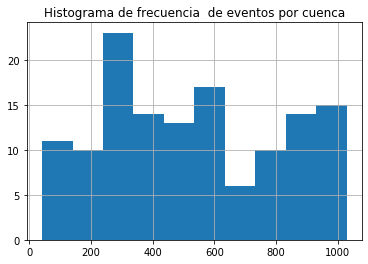

In [29]:
plt.title('Histograma de frecuencia  de eventos por cuenca')
cuenta_extremos['caudal_extremo_count'].hist()

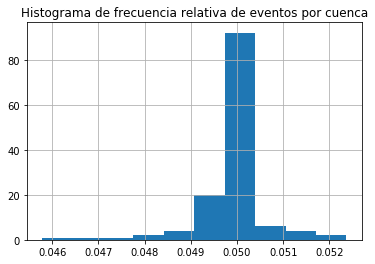

In [30]:
plt.title('Histograma de frecuencia relativa de eventos por cuenca')
cuenta_extremos['extremos_relativo'].hist()

A primera vista si vemos sólo la frecuencia de los eventos extremos, podriamos concluir que existen cuencas que tienen mas probabilidad de tener este tipo de eventos de caudal, pero cuando ajustamos por la cantidad de observaciones que tiene cada estación, entonces vemos que es obvio que esta medida está muy cercana al 5% para todas las estaciones por que es la forma por la cual se construyó la variable. 

Por eso para analizar diferencias entre cuencas debemos ver por ejemplo cual es el promedio del caudal **dado** que hubo un evento de caudal extremo en una cuenca

In [31]:
media_extremos = merged[['codigo_estacion', 'caudal']][merged['caudal_extremo'] == 1]
media_extremos = media_extremos.groupby('codigo_estacion').mean().add_suffix('_extremo_promedio').reset_index()
media_extremos.head(10)

,codigo_estacion,caudal_extremo_promedio
0,1020003,1.307738
1,1021001,8.441225
2,1050004,0.602824
3,1211001,8.635671
4,2103003,0.187350
5,2104002,2.346156
6,2104003,2.010167
7,2105001,7.238778
8,2105002,2.285383
9,2105005,1.409248


In [32]:
media_extremos['caudal_extremo_promedio'].describe()

count     133.000000
mean      345.339330
std       545.644268
min         0.187350
25%        18.543367
50%        84.948025
75%       536.247196
max      3170.915094
Name: caudal_extremo_promedio, dtype: float64

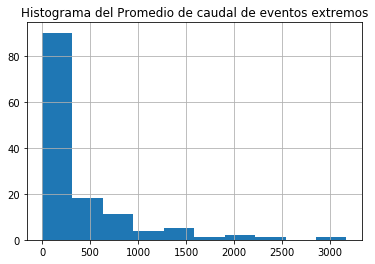

In [33]:
plt.title('Histograma del Promedio de caudal de eventos extremos')
media_extremos['caudal_extremo_promedio'].hist()

Podemos ver la medida de caudal extremo varía mucho entre diferentes cuencas, ya que por ejemplo para el 25% inferior de los eventos de caudal extremo ocurrieron con menos de 18 unidades, pero el 25% estos sólo ocurrieron con mas de 536 unidades. Esto probablemente se debe a condiciones geográficas como el tamaño de la cuenca

### Eventos a través del tiempo

Creamos una tabla agrupando los eventos ocurridos por año, relativo a la cantidad de observaciones

In [34]:
count_caudal_extremo = merged[['ano', 'caudal_extremo', 'temp_extremo', 'precip_extremo']]\
                    .groupby(['ano']).sum().add_suffix('_Sum').reset_index()
total_medidas_caudal = merged[['ano', 'caudal_extremo', 'temp_extremo', 'precip_extremo']]\
                    .groupby(['ano']).count().add_suffix('_Count').reset_index()
eventos_relativo = count_caudal_extremo.merge(total_medidas_caudal, on=['ano'], how='right')
eventos_relativo['caudal_porcentual'] = eventos_relativo['caudal_extremo_Sum'] / eventos_relativo['caudal_extremo_Count']
eventos_relativo['temp_porcentual'] = eventos_relativo['temp_extremo_Sum'] / eventos_relativo['temp_extremo_Count']
eventos_relativo['precp_porcentual'] = eventos_relativo['precip_extremo_Sum'] / eventos_relativo['precip_extremo_Count']
eventos_relativo.head(5)

,ano,caudal_extremo_Sum,temp_extremo_Sum,precip_extremo_Sum,caudal_extremo_Count,temp_extremo_Count,precip_extremo_Count,caudal_porcentual,temp_porcentual,precp_porcentual
0,1960,248,13.0,179.0,9979,307,7884,0.024852,0.042345,0.022704
1,1961,469,16.0,328.0,9862,344,8048,0.047556,0.046512,0.040755
2,1962,243,121.0,195.0,11003,2203,9449,0.022085,0.054925,0.020637
3,1963,884,128.0,709.0,13346,1997,11682,0.066237,0.064096,0.060692
4,1964,628,102.0,329.0,14150,2726,11937,0.044382,0.037417,0.027561


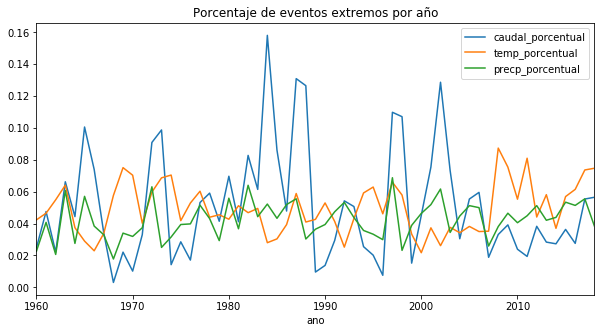

In [35]:
eventos_relativo[['ano', 'caudal_porcentual', 'temp_porcentual', 'precp_porcentual']].set_index('ano')\
                .plot(title='Porcentaje de eventos extremos por año', figsize=(10,5))

Al ver este gráfico relativo de incidentes extremos por año para cada medición, no me parece claro que exista una tendencia para decir que se han vuelto más comunes. Quizás los eventos de temperatura muestran una pequeña alza en el último periódo a partir del 2005, pero los eventos de caudal fueron mucho mas frecuentes en decadas pasadas

## Modelando caudal extremo

Creare algunas variables que creo se relacionan con el hecho de tener un evento de caudal extremo:
* media movil ultimos 3 dias de caudal
* media movil ultimos 3 dias de temperatura
* media movil ultimos 3 dias de precipitacion
* % de eventos de caudal extremo en los ultimos 3 dias
* caudal dia anterior
* temperatura dia anterior
* precipitacion dia anterior
* caudal acumulado 3 dias anteriores
* precipitacion acumulada 3 dias anteriores


In [36]:
# creacion de variables

merged = merged.set_index('fecha').sort_index()

merged['moving_caudal'] = merged.groupby('codigo_estacion')['caudal'].transform(lambda x: x.rolling(3, 3)\
                                                                                .mean().shift(1))
merged['moving_temp'] = merged.groupby('codigo_estacion')['temp_max_promedio'].transform(lambda x: x.rolling(3, 3)\
                                                                                .mean().shift(1))
merged['moving_precp'] = merged.groupby('codigo_estacion')['precip_promedio'].transform(lambda x: x.rolling(3, 3)\
                                                                               .mean().shift(1))
merged['dia_anterior_caudal'] = merged.groupby('codigo_estacion')['caudal'].transform(lambda x: x.rolling(1, 1)\
                                                                                .mean().shift(1))
merged['dia_anterior_temp'] = merged.groupby('codigo_estacion')['temp_max_promedio'].transform(lambda x: x.rolling(1, 1)\
                                                                                .mean().shift(1))
merged['dia_anterior_precp'] = merged.groupby('codigo_estacion')['precip_promedio'].transform(lambda x: x.rolling(1, 1)\
                                                                                .mean().shift(1))

merged['pct_caudal_extremo'] = merged.groupby('codigo_estacion')['caudal_extremo'].transform(lambda x: x.rolling(3, 3)\
                                                                                .mean().shift(1))

merged['caudal_acumulado'] = merged.groupby('codigo_estacion')['caudal'].transform(lambda x: x.rolling(3, 3)\
                                                                                .sum().shift(1))

merged['precp_acumulado'] = merged.groupby('codigo_estacion')['precip_promedio'].transform(lambda x: x.rolling(3, 3)\
                                                                                .sum().shift(1))
merged.head(5)

,codigo_estacion,caudal,precip_promedio,temp_max_promedio,mes,ano,caudal_extremo,temp_extremo,precip_extremo,estacion,...,p95_precp,moving_caudal,moving_temp,moving_precp,dia_anterior_caudal,dia_anterior_temp,dia_anterior_precp,pct_caudal_extremo,caudal_acumulado,precp_acumulado
fecha,,,,,,,,,,,,,,,,,,,,,
1960-01-02,4308001,3.78,0.0,NaN,1,1960,0,NaN,0.0,verano,...,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-02,8132001,1.10,0.0,NaN,1,1960,0,NaN,0.0,verano,...,5.71100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-02,9123001,59.00,NaN,NaN,1,1960,0,NaN,NaN,verano,...,13.87000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-02,4558001,0.32,0.0,NaN,1,1960,0,NaN,0.0,verano,...,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-02,2110002,3.60,NaN,NaN,1,1960,1,NaN,NaN,verano,...,3.30317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Crearemos nuestro dataframe para entrenamiento y eliminaremos las filas con NaN

In [37]:
len(merged)

1411180

In [38]:
dataset = merged[[ 'caudal', 'precip_promedio', 'temp_max_promedio',
       'caudal_extremo', 'estacion', 'p95_caudal', 'p95_temp',
       'p95_precp', 'moving_caudal', 'moving_temp', 'moving_precp', 
       'dia_anterior_caudal', 'dia_anterior_temp', 'dia_anterior_precp', 
       'pct_caudal_extremo', 'caudal_acumulado', 'precp_acumulado']] 

dataset = dataset.dropna(axis=0)
len(dataset)

1243716

In [39]:
dataset.caudal_extremo.value_counts()

0    1181415
1      62301
Name: caudal_extremo, dtype: int64

Tenemos un dataset muy desbalanceado donde solo tenemos 5% de eventos extremos, por lo que accuracy no es una metrica muy efectiva (si marcaramos todo como No Extremo lograriamos 95% de efectividad).

Por eso deberemos explorar metricas como precision y recall para ver si el modelo efectivamente logra reconocer los eventos extremos


Ademas eliminaremos las medidas del mismo dia ya que si queremos predecir para el futuro es data que no está disponible. El modelo usa las siguientes features:

* promedio ultimos 3 dias caudal
* promedio ultimos 3 dias temperatura
* promedio ultimos 3 dias precipitacion
* caudal dia anterior
* temp max dia anterior
* precipitacion dia anterior
* caudal acumulado ultimos 3 dias
* precipitacion acumulada ultimos 3 dias
* porcentaje de eventos de caudal extremos en los ultimos 7 dias

Quizas usar datos del dia anterior puede ser dificil (si se necesita tiempo para predecir), pero aun así estos podrían ser forecasts hechos con otros modelos, lo cual agregaría un poco de ruido pero permitiria hacer una mejor prediccion. 

En conclusión el modelo una vez entrenado debe ser aplicado diariamente para predecir si habrá un evento extremo al dia siguiente.

Para dividir el dataset en train y test haremos un split usando el 75% de los datos para entrenamiendo y un 25% para testing, tomando en cuenta la dimension temporal, para esto veremos hasta que fecha deberemos hacer el corte

In [40]:
porcentaje_split = pd.DataFrame(dataset.index.value_counts()).sort_index()
porcentaje_split['cum_sum'] = porcentaje_split['fecha'].cumsum()
porcentaje_split['cum_perc'] = 100*porcentaje_split['cum_sum']/porcentaje_split['fecha'].sum()
porcentaje_split[porcentaje_split.cum_perc > 75].head(5)

,fecha,cum_sum,cum_perc
2008-04-30,92,932869,75.006593
2008-05-01,89,932958,75.013749
2008-05-02,89,933047,75.020905
2008-05-03,87,933134,75.027900
2008-05-04,88,933222,75.034976


El corte es alrededor del año 2008, por lo que usaremos ese año para hacer el split entre train y test

In [41]:
X = dataset[[ 'moving_caudal', 'moving_temp', 
        'moving_precp', 'dia_anterior_caudal', 'dia_anterior_temp', 'dia_anterior_precp', 
       'pct_caudal_extremo', 'caudal_acumulado', 'precp_acumulado']] 

y = dataset['caudal_extremo']

X_train, X_test = X[:'2008-01-01'], X['2008-01-01':]
y_train, y_test = y[:'2008-01-01'], y['2008-01-01':]

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Modelare usando 2 algoritmos, logistic regression y decision trees para ver si existe alguna diferencia entre ellos. Dado lo imbalanceado de la data quizás los métodos de árbol puedan funcionar mejor

In [42]:
#con time series cross val

clf = LogisticRegression(random_state=123, solver='lbfgs', max_iter=1000).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test,y_test_pred))
print(accuracy_score(y_test,y_test_pred))
print('confusion matrix')
list1 = ["Actual No Extremo", "Actual Extremo"]
list2 = ["Predicted No Extremo", "Predicted Extremo"]

pd.DataFrame(confusion_matrix(y_test, y_test_pred),list1,list2)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    312127
           1       0.76      0.57      0.65      9989

    accuracy                           0.98    322116
   macro avg       0.87      0.78      0.82    322116
weighted avg       0.98      0.98      0.98    322116

0.9810720361608861
confusion matrix


,Predicted No Extremo,Predicted Extremo
Actual No Extremo,310303,1824
Actual Extremo,4273,5716


In [43]:
#con time series cross val

dt = DecisionTreeClassifier(random_state=123).fit(X_train, y_train)
y_test_pred = dt.predict(X_test)
print(classification_report(y_test,y_test_pred))
print(accuracy_score(y_test,y_test_pred))
print('confusion matrix')
list1 = ["Actual No Extremo", "Actual Extremo"]
list2 = ["Predicted No Extremo", "Predicted Extremo"]

pd.DataFrame(confusion_matrix(y_test, y_test_pred),list1,list2)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    312127
           1       0.51      0.58      0.54      9989

    accuracy                           0.97    322116
   macro avg       0.75      0.78      0.76    322116
weighted avg       0.97      0.97      0.97    322116

0.9695140880924884
confusion matrix


,Predicted No Extremo,Predicted Extremo
Actual No Extremo,306528,5599
Actual Extremo,4221,5768


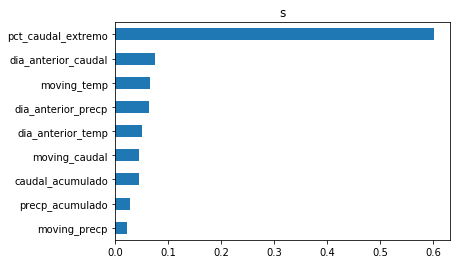

In [44]:
feat_importances = pd.Series(dt.feature_importances_, index=X.columns).sort_values()
feat_importances.plot(kind='barh', title='s')

Ambos modelos logran un 57% de recall , pero la regresion logística tuvo un 75% de precision, comparado con el árbol de decisión que tuvo 50%. 

No es malo para ser un evento bien extremo, el único gran problema es que la variable que más explica la predicción del modelo es el hecho de que en días anteriores existan eventos extremos de caudal. En la vida real creo que cualquier persona con dos dedos de frente podría decir "es probable que pase un evento extremo de caudal, dado que ocurrió uno recientemente, tuvimos precipitaciones y un caudal alto el dia anterior", por lo que el modelo ***no es muy útil***

Text(0, 0.5, 'Precision')

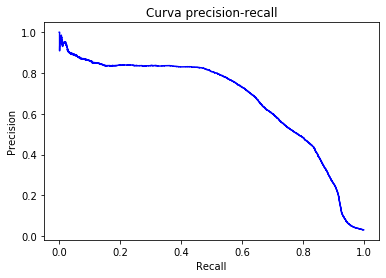

In [45]:
precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])

plt.step(recall, precision, color='b')
plt.title('Curva precision-recall')
plt.xlabel('Recall')
plt.ylabel('Precision')


En la curva precision recall podemos ver que para capturar un 70% de los eventos extremos, tendriamos una precisión de alrededor de 60%. Si el modelo no usara información acerca de eventos extremos pasados en la cercanía me parecería util. Pero creo que de esta manera no sirve de mucho 

### Bonus : Si no consideramos el hecho de saber que un % de los dias anteriores fue dia con caudal extremo, obtenemos los siguientes resultados.

In [46]:
X = dataset[[ 'moving_caudal', 'moving_temp', 
        'moving_precp', 'dia_anterior_caudal', 'dia_anterior_temp', 'dia_anterior_precp', 
         'caudal_acumulado', 'precp_acumulado']] 

y = dataset['caudal_extremo']

X_train, X_test = X[:'2008-01-01'], X['2008-01-01':]
y_train, y_test = y[:'2008-01-01'], y['2008-01-01':]

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
#con time series cross val

clf = LogisticRegression(random_state=123, solver='lbfgs', max_iter=1000).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test,y_test_pred))
print(accuracy_score(y_test,y_test_pred))
print('confusion matrix')
list1 = ["Actual No Extremo", "Actual Extremo"]
list2 = ["Predicted No Extremo", "Predicted Extremo"]

pd.DataFrame(confusion_matrix(y_test, y_test_pred),list1,list2)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    312127
           1       0.52      0.08      0.14      9989

    accuracy                           0.97    322116
   macro avg       0.75      0.54      0.56    322116
weighted avg       0.96      0.97      0.96    322116

0.9692253722261546
confusion matrix


,Predicted No Extremo,Predicted Extremo
Actual No Extremo,311383,744
Actual Extremo,9169,820


In [48]:
#con time series cross val

dt = DecisionTreeClassifier(random_state=123).fit(X_train, y_train)
y_test_pred = dt.predict(X_test)
print(classification_report(y_test,y_test_pred))
print(accuracy_score(y_test,y_test_pred))
print('confusion matrix')
list1 = ["Actual No Extremo", "Actual Extremo"]
list2 = ["Predicted No Extremo", "Predicted Extremo"]

pd.DataFrame(confusion_matrix(y_test, y_test_pred),list1,list2)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96    312127
           1       0.10      0.20      0.13      9989

    accuracy                           0.92    322116
   macro avg       0.54      0.57      0.54    322116
weighted avg       0.95      0.92      0.93    322116

0.9191564529548362
confusion matrix


,Predicted No Extremo,Predicted Extremo
Actual No Extremo,294102,18025
Actual Extremo,8016,1973


Los modelos funcionan mucho peor, no se si es correcto afirmar que hay data leakage porque no estamos mezclando data de entrenamiento con test, pero podría concluir que el modelo basicamente es inservible cuando no hay eventos de caudal previos en días cercanos. 

### Probando downsampling

Probaré hacer downsampling, para ver si quizás el modelo se ajusta mejor, creo que dado a que es un dataset desbalanceado donde muchos días no pasa nada, el modelo tiene a querer decir que nada va a pasar

In [49]:
X = dataset[[ 'moving_caudal', 'moving_temp', 
        'moving_precp', 'dia_anterior_caudal', 'dia_anterior_temp', 'dia_anterior_precp', 
         'caudal_acumulado', 'precp_acumulado']] 

y = dataset['caudal_extremo']


X_train, X_test = X[:'2008-01-01'], X['2008-01-01':]
y_train, y_test = y[:'2008-01-01'], y['2008-01-01':]

scaler = StandardScaler().fit(X_train)

X = pd.concat([X_train, y_train], axis=1)

no_extremo = X[X.caudal_extremo==0]
extremo = X[X.caudal_extremo==1]

no_extremo_downsample = resample(no_extremo,
                                replace = False, 
                                n_samples = len(extremo)*3,
                                random_state = 33) 

downsampled = pd.concat([no_extremo_downsample, extremo])

print(downsampled.caudal_extremo.value_counts())

0    156945
1     52315
Name: caudal_extremo, dtype: int64


In [50]:
y_train = downsampled.caudal_extremo
X_train = downsampled.drop('caudal_extremo', axis=1)

In [51]:
#con time series cross val

clf = LogisticRegression(random_state=123, solver='lbfgs', max_iter=1000).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test,y_test_pred))
print(accuracy_score(y_test,y_test_pred))
print('confusion matrix')
list1 = ["Actual No Extremo", "Actual Extremo"]
list2 = ["Predicted No Extremo", "Predicted Extremo"]

pd.DataFrame(confusion_matrix(y_test, y_test_pred),list1,list2)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97    312127
           1       0.23      0.26      0.25      9989

    accuracy                           0.95    322116
   macro avg       0.61      0.62      0.61    322116
weighted avg       0.95      0.95      0.95    322116

0.9505147214047114
confusion matrix


,Predicted No Extremo,Predicted Extremo
Actual No Extremo,303550,8577
Actual Extremo,7363,2626


Text(0, 0.5, 'Precision')

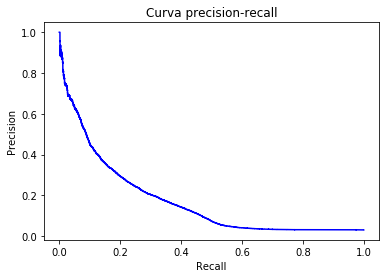

In [52]:
precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])

plt.step(recall, precision, color='b')
plt.title('Curva precision-recall')
plt.xlabel('Recall')
plt.ylabel('Precision')


En este caso el downsampling hace que nuestro modelo pierda mucha precision y se vuelve inservible

En conclusion creo que para modelar correctamente los eventos extremos peligrosos, se debe identificar primero la cuencas que son mas peligrosas para la sociedad y a partir de eso crear modelos individuales para cada una de ellas tomando en cuenta características geográficas propias de cada una de ellas. Este análisis tan general difícilmente puede modelar este fenómeno